## Persiapan

In [14]:
# Import Library
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import gensim
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
# Load Dataset

df = pd.read_csv("D:\File Kuliah D\Semester 7\Pemro Teks\Klasifikasi Data\data_manual.csv")  # sesuaikan path bila perlu

print("Dataset berhasil dimuat:")
display(df.head())

print("\nJumlah data per label:")
print(df['label_manual'].value_counts())

print("\nCek missing values:")
print(df.isnull().sum())

Dataset berhasil dimuat:


,review,preprocessed_text,score,label_manual
0,saya tidak merasa melakukan pembayaran tiba ti...,bayar bayar nila ribu mohon bantuanya,1,negatif
1,aneh bjir GPS nya lompat lompat,aneh bjir lompat lompat,2,negatif
2,Kenapa APK ini langsung Main Tarik Uang melalu...,aplikasi langsung main tarik uang aplikasi pla...,1,negatif
3,jalan,lari bersepeda dll dapat kita lihat berapa me...,5,positif
4,awas aplikasi ini nyuri saldo dari rek.ewalet ...,awas aplikasi nyuri saldo rekewalet akses korban,5,negatif



Jumlah data per label:
label_manual
negatif    100
positif    100
netral      50
Name: count, dtype: int64

Cek missing values:
review               0
preprocessed_text    0
score                0
label_manual         0
dtype: int64


In [16]:
# Preprocessing

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z ]', ' ', text)
    text = re.sub('\s+', ' ', text).strip()
    return text

def preprocess(text):
    text = clean_text(text)
    tokens = [w for w in text.split() if w not in stop_words]
    
    # stemming
    stemmed = [stemmer.stem(w) for w in tokens]
    # lemmatizing
    lemmatized = [lemmatizer.lemmatize(w) for w in stemmed]
    
    return " ".join(lemmatized)

df['clean_text'] = df['review'].apply(preprocess)

print("Preprocessing selesai.")
df[['review','clean_text','label_manual']].head()

Preprocessing selesai.


,review,clean_text,label_manual
0,saya tidak merasa melakukan pembayaran tiba ti...,saya tidak merasa melakukan pembayaran tiba ti...,negatif
1,aneh bjir GPS nya lompat lompat,aneh bjir gp nya lompat lompat,negatif
2,Kenapa APK ini langsung Main Tarik Uang melalu...,kenapa apk ini langsung main tarik uang melalu...,negatif
3,jalan,jalan,positif
4,awas aplikasi ini nyuri saldo dari rek.ewalet ...,awa aplikasi ini nyuri saldo dari rek ewalet d...,negatif


In [17]:
# Train-Test Split

X = df['preprocessed_text']
y = df['label_manual']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 200
Test size: 50


## EKSTRAKSI FITUR (Beberapa Pilihan Model)

In [18]:
# TF-IDF
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [19]:
# Bag of Words
bow = CountVectorizer()
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

In [20]:
# Word2Vec

tokenized_train = [t.split() for t in X_train]
w2v_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=2)

def embed(sentence):
    words = [w for w in sentence.split() if w in w2v_model.wv]
    if len(words) == 0:
        return np.zeros(100)
    return np.mean(w2v_model.wv[words], axis=0)

X_train_w2v = np.array([embed(text) for text in X_train])
X_test_w2v = np.array([embed(text) for text in X_test])

In [21]:
# GloVe embedding

import gensim.downloader as api
glove = api.load("glove-wiki-gigaword-50")

def embed_glove(sentence):
    words = [w for w in sentence.split() if w in glove]
    if len(words) == 0:
        return np.zeros(50)
    return np.mean([glove[w] for w in words], axis=0)

X_train_glove = np.array([embed_glove(t) for t in X_train])
X_test_glove = np.array([embed_glove(t) for t in X_test])

## Training 4 Model Logistic Regression

In [22]:
# Logistic Regression + TF-IDF
logreg_tfidf = LogisticRegression(max_iter=32)
logreg_tfidf.fit(X_train_tfidf, y_train)

pred_tfidf = logreg_tfidf.predict(X_test_tfidf)

print("MODEL: Logistic Regression + TF-IDF")
print("Accuracy:", accuracy_score(y_test, pred_tfidf))
print("\nClassification Report:\n", classification_report(y_test, pred_tfidf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred_tfidf))

MODEL: Logistic Regression + TF-IDF
Accuracy: 0.8

Classification Report:
               precision    recall  f1-score   support

     negatif       0.83      0.95      0.88        20
      netral       1.00      0.10      0.18        10
     positif       0.77      1.00      0.87        20

    accuracy                           0.80        50
   macro avg       0.87      0.68      0.65        50
weighted avg       0.84      0.80      0.74        50


Confusion Matrix:
 [[19  0  1]
 [ 4  1  5]
 [ 0  0 20]]


In [23]:
# Logistic Regression + BoW
logreg_bow = LogisticRegression(max_iter=32)
logreg_bow.fit(X_train_bow, y_train)

pred_bow = logreg_bow.predict(X_test_bow)

print("MODEL: Logistic Regression + BoW")
print("Accuracy:", accuracy_score(y_test, pred_bow))
print("\nClassification Report:\n", classification_report(y_test, pred_bow))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred_bow))

MODEL: Logistic Regression + BoW
Accuracy: 0.78

Classification Report:
               precision    recall  f1-score   support

     negatif       0.84      0.80      0.82        20
      netral       1.00      0.30      0.46        10
     positif       0.71      1.00      0.83        20

    accuracy                           0.78        50
   macro avg       0.85      0.70      0.71        50
weighted avg       0.82      0.78      0.75        50


Confusion Matrix:
 [[16  0  4]
 [ 3  3  4]
 [ 0  0 20]]


In [24]:
# Logistic Regression + Word2Vec
logreg_w2v = LogisticRegression(max_iter=32)
logreg_w2v.fit(X_train_w2v, y_train)

pred_w2v = logreg_w2v.predict(X_test_w2v)

print("MODEL: Logistic Regression + Word2Vec")
print("Accuracy:", accuracy_score(y_test, pred_w2v))
print("\nClassification Report:\n", classification_report(y_test, pred_w2v))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred_w2v))

MODEL: Logistic Regression + Word2Vec
Accuracy: 0.62

Classification Report:
               precision    recall  f1-score   support

     negatif       0.59      0.85      0.69        20
      netral       0.00      0.00      0.00        10
     positif       0.67      0.70      0.68        20

    accuracy                           0.62        50
   macro avg       0.42      0.52      0.46        50
weighted avg       0.50      0.62      0.55        50


Confusion Matrix:
 [[17  0  3]
 [ 6  0  4]
 [ 6  0 14]]


c:\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
# Logistic Regression + GloVe
logreg_glove = LogisticRegression(max_iter=32)
logreg_glove.fit(X_train_glove, y_train)

pred_glove = logreg_glove.predict(X_test_glove)

print("MODEL: Logistic Regression + GloVe")
print("Accuracy:", accuracy_score(y_test, pred_glove))
print("\nClassification Report:\n", classification_report(y_test, pred_glove))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred_glove))

MODEL: Logistic Regression + GloVe
Accuracy: 0.64

Classification Report:
               precision    recall  f1-score   support

     negatif       0.62      0.75      0.68        20
      netral       0.40      0.40      0.40        10
     positif       0.81      0.65      0.72        20

    accuracy                           0.64        50
   macro avg       0.61      0.60      0.60        50
weighted avg       0.66      0.64      0.64        50


Confusion Matrix:
 [[15  5  0]
 [ 3  4  3]
 [ 6  1 13]]


## Perbandingan Hasil

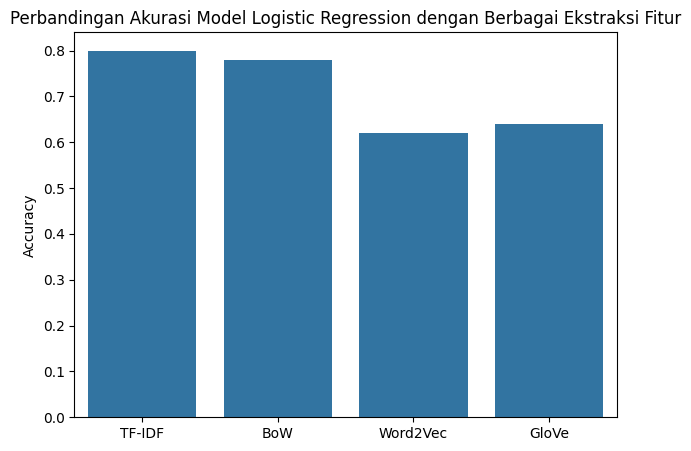

In [26]:
# Visualisasi Perbandingan Akurasi

accuracies = {
    "TF-IDF": accuracy_score(y_test, pred_tfidf),
    "BoW": accuracy_score(y_test, pred_bow),
    "Word2Vec": accuracy_score(y_test, pred_w2v),
    "GloVe": accuracy_score(y_test, pred_glove)
}

plt.figure(figsize=(7,5))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title("Perbandingan Akurasi Model Logistic Regression dengan Berbagai Ekstraksi Fitur")
plt.ylabel("Accuracy")
plt.show()
